In [1]:
include("/Net/Groups/BGI/people/gkraemer/progs/data_cube/julia/notebooks/stuff.jl")

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5301713715332242772\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-10876278123518076082\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/user/gkraemer//assetserver/549eec07f928a744cd5cefcd9652eb9af414188d-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-5301713715332242772\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

┌ Warning: Package RCall does not have AxisArrays in its dependencies:
│ - If you have RCall checked out for development and have
│   added AxisArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RCall
│ Loading AxisArrays into RCall from project dependency, future warnings for RCall are suppressed.
└ @ nothing nothing:840
┌ Warning: RCall.jl: Loading required package: sp
└ @ RCall /Net/Groups/BGI/people/gkraemer/.julia_atacama/packages/RCall/29zDq/src/io.jl:113
┌ Warning: RCall.jl: Checking rgeos availability: TRUE
└ @ RCall /Net/Groups/BGI/people/gkraemer/.julia_atacama/packages/RCall/29zDq/src/io.jl:113
┌ Warning: RCall.jl: Loading required package: zoo
│ 
│ Attaching package: 'zoo'
│ 
│ The following objects are masked from 'package:base':
│ 
│     as.Date, as.Date.numeric
│ 
│ Loading required package: sandwich
└ @ RCall /Net/Groups/BGI/people/gkraemer/.julia_atacama/packag

PcaAxis             Axis with 12 elements: PCA_1 PCA_2 .. PCA_11 PCA_12 

In [2]:
pca_msc_cube = loadCube(joinpath(cubes_base_dir, "pca_msc_cube"))

Memory mapped cube with the following dimensions
MSC                 Axis with 46 Elements from 1900-01-01 to 1900-12-27
PcaAxis             Axis with 12 elements: PCA_1 PCA_2 .. PCA_11 PCA_12 
Lon                 Axis with 1440 Elements from -179.875 to 179.875
Lat                 Axis with 720 Elements from 89.875 to -89.875
Total size: 2.67 GB


In [69]:
area([0.0, 1.0, 0.0], [0.0, 0.0, 1.0])

0.5

In [91]:
pca_msc_cube

Memory mapped cube with the following dimensions
MSC                 Axis with 46 Elements from 1900-01-01 to 1900-12-27
PcaAxis             Axis with 12 elements: PCA_1 PCA_2 .. PCA_11 PCA_12 
Lon                 Axis with 1440 Elements from -179.875 to 179.875
Lat                 Axis with 720 Elements from 89.875 to -89.875
Total size: 2.67 GB


In [107]:
area(
    convert(Array, pca_msc_cube[:, 1, places[1][6], 720 - places[2][6]]),
    convert(Array, pca_msc_cube[:, 2, places[1][6], 720 - places[2][6]])
)    

6.089968f0

In [89]:
cube_hysteresis_12

Memory mapped cube with the following dimensions
Lon                 Axis with 1440 Elements from -179.875 to 179.875
Lat                 Axis with 720 Elements from 89.875 to -89.875
Total size: 4.94 MB


In [108]:
cube_hysteresis_12[places[1][6], 720 - places[2][6]]

6.089968f0

In [72]:
pca_msc_cube

Memory mapped cube with the following dimensions
MSC                 Axis with 46 Elements from 1900-01-01 to 1900-12-27
PcaAxis             Axis with 12 elements: PCA_1 PCA_2 .. PCA_11 PCA_12 
Lon                 Axis with 1440 Elements from -179.875 to 179.875
Lat                 Axis with 720 Elements from 89.875 to -89.875
Total size: 2.67 GB


In [92]:
rmprocs(procs())
addprocs(40)
@everywhere begin
    """
    Area inside a polygon, will be positive if anticlockwise, 
    negative if clockwise, self intersecting polygons will cancel out (partially?).
    """
    function area(x::Vector{T}, y::Vector{T})::T where T
        @assert length(x) == length(y)

        a = zero(T)
        @inbounds for i in 2:(length(x) - 1)
            a += x[i] * (y[i + 1] - y[i - 1])
        end
        a += x[1] * (y[2] - y[end])
        a /= 2
        return a
    end
end
    
cube_hysteresis_12 = mapCube(
    pca_msc_cube,
    indims = InDims("PcaAxis", "MSC"),
    outdims = OutDims()
) do xout, xin
    
    x = xin[1, :]
    y = xin[2, :]
    
    if any(ismissing, x) || any(ismissing, y)
        xout[1] = missing
    else
        xout[1] = area(x, y)
    end    
end

cube_hysteresis_13 = mapCube(
    pca_msc_cube,
    indims = InDims("PcaAxis", "MSC"),
    outdims = OutDims()
) do xout, xin
    
    x = xin[1, :]
    y = xin[3, :]
    
    if any(ismissing, x) || any(ismissing, y)
        xout[1] = missing
    else
        xout[1] = area(x, y)
    end    
end

cube_hysteresis_23 = mapCube(
    pca_msc_cube,
    indims = InDims("PcaAxis", "MSC"),
    outdims = OutDims()
) do xout, xin
    
    x = xin[2, :]
    y = xin[3, :]
    
    if any(ismissing, x) || any(ismissing, y)
        xout[1] = missing
    else
        xout[1] = area(x, y)
    end    
end

rmprocs(procs())

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Distributed/src/cluster.jl:928
Progress: 100%|█████████████████████████████████████████| Time: 0:02:14m9m
Progress: 100%|█████████████████████████████████████████| Time: 0:02:1139m
Progress: 100%|█████████████████████████████████████████| Time: 0:02:0939m
┌ Warning: rmprocs: process 1 not removed
└ @ Distributed /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/Distributed/src/cluster.jl:928


Task (done) @0x00007fe436fc1120

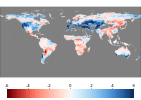

In [93]:
plotMAP(cube_hysteresis_12, colorm = colormap("RdBu"), dmin = -6, dmax = 6)

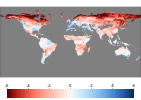

In [94]:
plotMAP(cube_hysteresis_13, colorm = colormap("RdBu"), dmin = -6, dmax = 6)

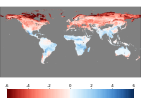

In [95]:
plotMAP(cube_hysteresis_23, colorm = colormap("RdBu"), dmin = -6, dmax = 6)

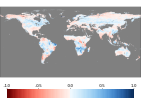

In [11]:
plotMAP(cube_hysteresis_12 - cube_hysteresis_13, colorm = colormap("RdBu"), dmin = -1, dmax = 1)

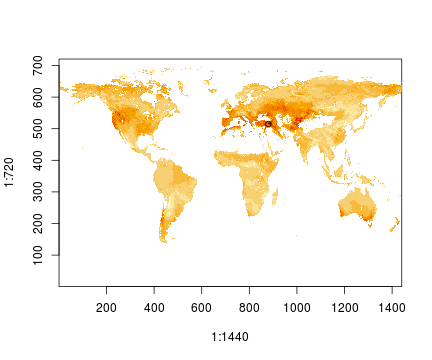

RObject{NilSxp}
NULL


In [106]:
R"""
image(1:1440, 1:720, hyst12)
points(880, 515)
"""

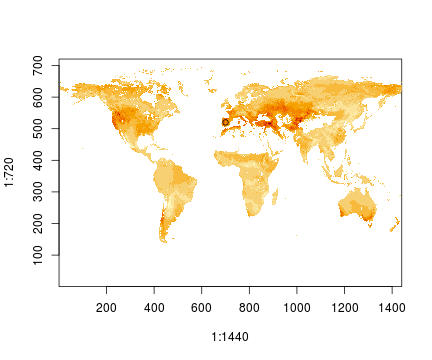

RObject{NilSxp}
NULL


In [116]:
R"""
image(1:1440, 1:720, hyst12)
points(700, 520)
"""

In [117]:
cube_hysteresis_12[700, 720 - 520]

5.754362f0

In [249]:
R"""
library(viridis)
data(coastsCoarse, package = "rworldmap")

pdf($(joinpath(fig_path, "hysteresis.pdf")), width = 10*2/3, height = 10)
layout(matrix(c(1:3), ncol = 1))

pal1 <- c("#543005", "#8C510A", "#BF812D", "#DFC27D", 
          "#F6E8C3", "#F5F5F5", "#C7EAE5", "#80CDC1", 
          "#35978F", "#01665E", "#003C30")
pal1 <- colorRampPalette(colors = pal1)(100)

pal2 <- rev(c("#67001f", "#b2182b","#d6604d", "#f4a582",
              "#fddbc7", "#f7f7f7", "#d1e5f0","#92c5de",
              "#4393c3", "#2166ac","#053061"))
pal2 <- colorRampPalette(colors = pal2)(100)

pal3 <- c("#7f3b08","#b35806","#e08214","#fdb863",
          "#fee0b6","#f7f7f7","#d8daeb","#b2abd2",
          "#8073ac","#542788","#2d004b")
pal3 <- colorRampPalette(colors = pal3)(100)

hyst12 <- $(cube_hysteresis_12[:,:] |> collect |> missing_to_nan |> x -> x[:, end:-1:1])
hyst13 <- $(cube_hysteresis_13[:,:] |> collect |> missing_to_nan |> x -> x[:, end:-1:1])
hyst23 <- $(cube_hysteresis_23[:,:] |> collect |> missing_to_nan |> x -> x[:, end:-1:1])

crange12 <- 0.8 * (max(abs(range(hyst12, na.rm = TRUE))) %>% { c(-., .) })
crange13 <- 0.8 * (max(abs(range(hyst13, na.rm = TRUE))) %>% { c(-., .) })
crange23 <- 0.8 * (max(abs(range(hyst23, na.rm = TRUE))) %>% { c(-., .) })

hist12 <- hist(hyst12, plot = FALSE)
hist13 <- hist(hyst13, plot = FALSE)
hist23 <- hist(hyst23, plot = FALSE)

############ maps
par(mar = c(0, 0, 0, 0))
image(seq(-180, 180, by = 0.25), seq(-60, 90, by = 0.25), hyst12[, 120:720], zlim = crange12, col = pal1, useRaster = TRUE, bty = 'n', axes = FALSE)
plot(coastsCoarse, add = TRUE)
image(seq(-180, 180, by = 0.25), seq(-60, 90, by = 0.25), hyst13[, 120:720], zlim = crange13, col = pal2, useRaster = TRUE, bty = 'n', axes = FALSE)
plot(coastsCoarse, add = TRUE)
image(seq(-180, 180, by = 0.25), seq(-60, 90, by = 0.25), hyst23[, 120:720], zlim = crange23, col = pal3, useRaster = TRUE, bty = 'n', axes = FALSE)
plot(coastsCoarse, add = TRUE)

############ color bars and hists
par(fig = c(0.07, 0.10, (2 + 0.05) / 3, (2 + 0.5) / 3), new = TRUE, xpd = NA, mgp = c(2.2, 1, 0))
image(0:1, 
      seq(crange12[1], crange12[2], length.out = 100),
      t(seq(crange12[1], crange12[2], length.out = 100)), 
      col = pal1, useRaster = TRUE, xaxt = 'n', bty = 'n', las = 2, 
      #ylab = expression(atop("Area " * group("[", "std" ^ 2, "]"),
      #                       "clockwise"%<->% "counterclockwise")),
      ylab = expression("Area " * group("[", "std" ^ 2, "]")),
      xlab = NA
)
text(1, crange12[1], "clockwise", pos = 4)
text(1, crange12[2], "counterclockwise", pos = 4)
rect(1, hist12$breaks[-length(hist12$breaks)], 1 + 4 * hist12$density, hist12$breaks[-1])


par(fig = c(0.07, 0.10, (1 + 0.05) / 3, (1 + 0.5) / 3), new = TRUE, xpd = NA, mgp = c(2.2, 1, 0))
image(0:1, 
      seq(crange13[1], crange13[2], length.out = 100),
      t(seq(crange13[1], crange13[2], length.out = 100)), 
      col = pal2, useRaster = TRUE, xaxt = 'n', bty = 'n', las = 2, 
      #ylab = expression(atop("Area " * group("[", "std" ^ 2, "]"),
      #                       "clockwise"%<->% "counterclockwise")),
      ylab = expression("Area " * group("[", "std" ^ 2, "]")),
      xlab = NA
)
text(1, crange13[1], "clockwise", pos = 4)
text(1, crange13[2], "counterclockwise", pos = 4)
rect(1, hist13$breaks[-length(hist13$breaks)], 1 + 4 * hist13$density, hist13$breaks[-1])

par(fig = c(0.07, 0.10, 0.05 / 3, 0.5 / 3), new = TRUE, xpd = NA, mgp = c(2.2, 1, 0))
image(0:1, 
      seq(crange23[1], crange23[2], length.out = 100),
      t(seq(crange23[1], crange23[2], length.out = 100)), 
      col = pal3, useRaster = TRUE, xaxt = 'n', bty = 'n', las = 2, 
      #ylab = expression(atop("Area " * group("[", "std" ^ 2, "]"),
      #                       "clockwise"%<->% "counterclockwise")),
      ylab = expression("Area " * group("[", "std" ^ 2, "]")),
      xlab = NA
)
text(1, crange23[1], "clockwise", pos = 4)
text(1, crange23[2], "counterclockwise", pos = 4)
rect(1, hist23$breaks[-length(hist23$breaks)], 1 + 4 * hist23$density, hist23$breaks[-1])

######## decoration
grid.text("(a)", 0,   1, just = c(0, 1))
grid.text("(b)", 0, 2/3, just = c(0, 1))
grid.text("(c)", 0, 1/3, just = c(0, 1))


dev.off()
"""

show_pdf("https://localhost:8000/user/gkraemer/files/scratch/gkraemer/global_pca_j1/fig/hysteresis.pdf", width = 700, height = 1000)

(object { attributes=Dict(:type=>"application/pdf",:height=>"1000",:data=>"https://localhost:8000/user/gkraemer/files/scratch/gkraemer/global_pca_j1/fig/hysteresis.pdf",:width=>"700") }
  "pdf not found")

In [119]:
pca_msc_cube

Memory mapped cube with the following dimensions
MSC                 Axis with 46 Elements from 1900-01-01 to 1900-12-27
PcaAxis             Axis with 12 elements: PCA_1 PCA_2 .. PCA_11 PCA_12 
Lon                 Axis with 1440 Elements from -179.875 to 179.875
Lat                 Axis with 720 Elements from 89.875 to -89.875
Total size: 2.67 GB


In [246]:
R"""
pdf($(joinpath(fig_path, "area_example.pdf")), width = 7, height = 7 * 11/20)
par(mar = c(4, 4, 0, 0) + 0.1)
plot(c(-10, 10), c(-5, 6), type = "n", xlab = "x", ylab = "y", bty = "n")

area_poly <- function (x, y) {
    n <- length(x)

    a <- x[1] * (y[2] - y[n])
    for (i in 2:(n - 1)) {
        a <- a + x[i] * (y[i + 1] - y[i - 1])
    }
    a <- a + x[n] * (y[1] - y[n - 1])
    a <- a / 2

    return(a)
}

plot_poly <- function (x, y, xshift = 0, yshift = 0, label = "", arrow_pos = 15) {
    xx <- x + xshift
    yy <- y + yshift
    xx <- c(xx, xx[1])
    yy <- c(yy, yy[1])
    a <- sprintf("%0.2f", area_poly(x, y))
    lines(xx, yy, lwd = 2)
    text(min(xx) - 0.5, max(yy) + 0.5, paste(label, "Area = ", a))
    if (!is.na(arrow_pos))
        arrows(xx[arrow_pos], yy[arrow_pos], xx[arrow_pos + 1], yy[arrow_pos + 1], length = 0.1, lwd = 2)
}
"""


# somewhere in east asia with positive hysteresis 12
lat, lon = 42.1390871, 125.0747612

compx = 1
compy = 2

loni = axVal2Index(getAxis(LonAxis, pca_msc_cube), lon)
lati = axVal2Index(getAxis(LatAxis, pca_msc_cube), lat)

mscx = pca_msc_cube[:, compx, loni, lati] .|> Float64
mscy = pca_msc_cube[:, compy, loni, lati] .|> Float64

R"""
plot_poly($mscx, $mscy, -5, 2.5, "(a)")
"""

# spain with positive hysteresis 13
lat, lon = 39.2894848, -5.9888035

compx = 1
compy = 3

loni = axVal2Index(getAxis(LonAxis, pca_msc_cube), lon)
lati = axVal2Index(getAxis(LatAxis, pca_msc_cube), lat)

mscx = pca_msc_cube[:, compx, loni, lati] .|> Float64
mscy = pca_msc_cube[:, compy, loni, lati] .|> Float64

R"""
plot_poly($mscx, $mscy, 5, 5, "(b)", 20)
"""

#india monsoon
lat, lon = 22.375, 82.375
compx = 1
compy = 2

loni = axVal2Index(getAxis(LonAxis, pca_msc_cube), lon)
lati = axVal2Index(getAxis(LatAxis, pca_msc_cube), lat)

mscx = pca_msc_cube[:, compx, loni, lati] .|> Float64
mscy = pca_msc_cube[:, compy, loni, lati] .|> Float64

R"""
plot_poly($mscx, $mscy, 5, -2.5, "(d)", 1)
"""

# amazon
lat, lon = -2.625, -65.625
compx = 1
compy = 2

loni = axVal2Index(getAxis(LonAxis, pca_msc_cube), lon)
lati = axVal2Index(getAxis(LatAxis, pca_msc_cube), lat)

mscx = pca_msc_cube[:, compx, loni, lati] .|> Float64
mscy = pca_msc_cube[:, compy, loni, lati] .|> Float64

R"""
plot_poly($mscx, $mscy, -7, -2.5, "(c)", NA)
dev.off()
"""

show_pdf("https://localhost:8000/user/gkraemer/files/scratch/gkraemer/global_pca_j1/fig/area_example.pdf", width = 700, height = 500)

(object { attributes=Dict(:type=>"application/pdf",:height=>"500",:data=>"https://localhost:8000/user/gkraemer/files/scratch/gkraemer/global_pca_j1/fig/area_example.pdf",:width=>"700") }
  "pdf not found")

In [152]:
R"""?graphics::text"""

RObject{StrSxp}


text                 package:graphics                  R Documentation

_A_d_d _T_e_x_t _t_o _a _P_l_o_t

_D_e_s_c_r_i_p_t_i_o_n:

     'text' draws the strings given in the vector 'labels' at the
     coordinates given by 'x' and 'y'.  'y' may be missing since
     'xy.coords(x, y)' is used for construction of the coordinates.

_U_s_a_g_e:

     text(x, ...)
     
     ## Default S3 method:
      text(x, y = NULL, labels = seq_along(x$x), adj = NULL,
          pos = NULL, offset = 0.5, vfont = NULL,
          cex = 1, col = NULL, font = NULL, ...)
     
_A_r_g_u_m_e_n_t_s:

    x, y: numeric vectors of coordinates where the text 'labels' should
          be written.  If the length of 'x' and 'y' differs, the
          shorter one is recycled.

  labels: a character vector or expression specifying the _text_ to be
          written.  An attempt is made to coerce other language objects
          (names and calls) to expressions, and vectors and oth

In [123]:
plotTS(pca_msc_cube)

ErrorException: Axis ESDLPlots.FixedAx("time", "X Axis", true, true, 1) must be selected.

### Hysteresis example Figure

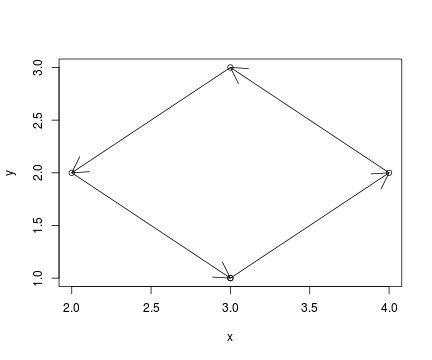

RObject{NilSxp}
NULL


In [176]:
R"""
x <- c(3, 4, 3, 2)
y <- c(1, 2, 3, 2)
n <- length(x)
x <- c(x, x[1])
y <- c(y, y[1])

plot(x, y)
arrows(x[-(n + 1)], y[-(n + 1)],
       x[-1],       y[-1])


"""